In [22]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn import linear_model, model_selection, preprocessing, metrics
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
from LSTM import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
train_path = "data/train.csv"
test_path = "data/test.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(df_train.shape, df_test.shape)
print("\nTotal NA values:", df_train.isna().sum().sum())

(7352, 563) (2947, 563)

Total NA values: 0


In [24]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [25]:
print(df_train["Activity"].value_counts(), "\n\n")
print(df_test["Activity"].value_counts())

Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64 


Activity
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64


In [26]:
activites = df_train["Activity"].unique()

class_map = {i : val for i, val in enumerate(activites)}
class_map_reverse = {key : val for val, key in class_map.items()}

print(class_map)

{0: 'STANDING', 1: 'SITTING', 2: 'LAYING', 3: 'WALKING', 4: 'WALKING_DOWNSTAIRS', 5: 'WALKING_UPSTAIRS'}


In [27]:
df_train["Activity"] = df_train["Activity"].apply(lambda x : class_map_reverse[x])
df_test["Activity"] = df_test["Activity"].apply(lambda x : class_map_reverse[x])

df_train.drop("subject", axis = 1, inplace = True)
df_test.drop("subject", axis = 1, inplace = True)

In [28]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,0
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,0
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,0
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,0
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,0


In [29]:
time_steps = 10

def create_sequences(X, y, time_steps = 5):
    X_, y_ = [], []
    n = X.shape[0]
    for i in np.arange(n - time_steps):
        X_.append(X[i:(i + time_steps)])
        y_.append(y[i + time_steps])
    return np.array(X_), np.array(y_)

X_train_ = df_train.drop("Activity", axis = 1).values
X_test_ = df_test.drop("Activity", axis = 1).values
y_train_ = df_train["Activity"].values
y_test_ = df_test["Activity"].values

X_train, y_train = create_sequences(X_train_, y_train_, time_steps)
X_test, y_test = create_sequences(X_test_, y_test_, time_steps)

print(X_train.shape, X_test.shape)

(7342, 10, 561) (2937, 10, 561)


In [30]:
num_features = X_train.shape[-1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ActivityLSTM(
    input_shape=num_features,
    num_classes=len(class_map),
    dropout=0.3
).to(device)

In [31]:
class ActivityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32

train_dataset = ActivityDataset(X_train, y_train)
test_dataset = ActivityDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
model = ActivityLSTM(input_shape=num_features, num_classes=len(class_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [62]:
num_epochs = 100

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/100 | Train Loss: 0.9459, Train Acc: 0.5552 | Val Loss: 0.6276, Val Acc: 0.7783
Epoch 5/100 | Train Loss: 0.2531, Train Acc: 0.9235 | Val Loss: 0.4610, Val Acc: 0.8641
Epoch 10/100 | Train Loss: 0.2323, Train Acc: 0.9375 | Val Loss: 0.2805, Val Acc: 0.9183
Epoch 15/100 | Train Loss: 0.2362, Train Acc: 0.9348 | Val Loss: 0.4072, Val Acc: 0.8927
Epoch 20/100 | Train Loss: 0.2174, Train Acc: 0.9406 | Val Loss: 0.3344, Val Acc: 0.8893
Epoch 25/100 | Train Loss: 0.1950, Train Acc: 0.9495 | Val Loss: 0.3702, Val Acc: 0.8917
Epoch 30/100 | Train Loss: 0.2783, Train Acc: 0.9030 | Val Loss: 0.3437, Val Acc: 0.8887
Epoch 35/100 | Train Loss: 0.1982, Train Acc: 0.9463 | Val Loss: 0.2981, Val Acc: 0.9145
Epoch 40/100 | Train Loss: 0.2067, Train Acc: 0.9440 | Val Loss: 0.3269, Val Acc: 0.9060
Epoch 45/100 | Train Loss: 0.1889, Train Acc: 0.9506 | Val Loss: 0.3177, Val Acc: 0.9091
Epoch 50/100 | Train Loss: 0.1900, Train Acc: 0.9495 | Val Loss: 0.4245, Val Acc: 0.8924
Epoch 55/100 | Train Lo

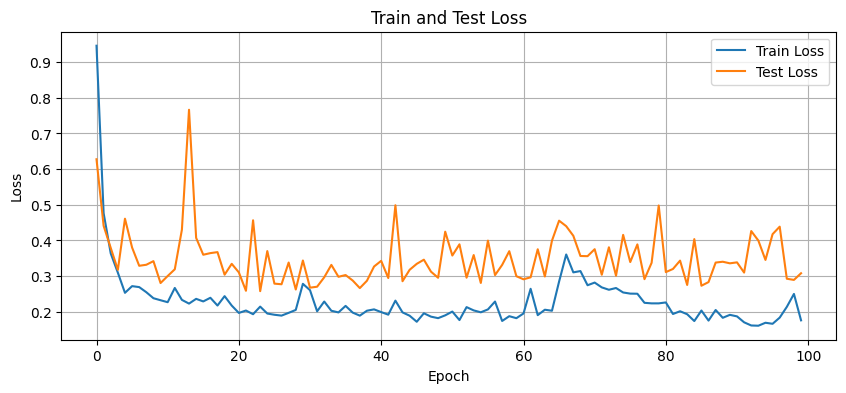

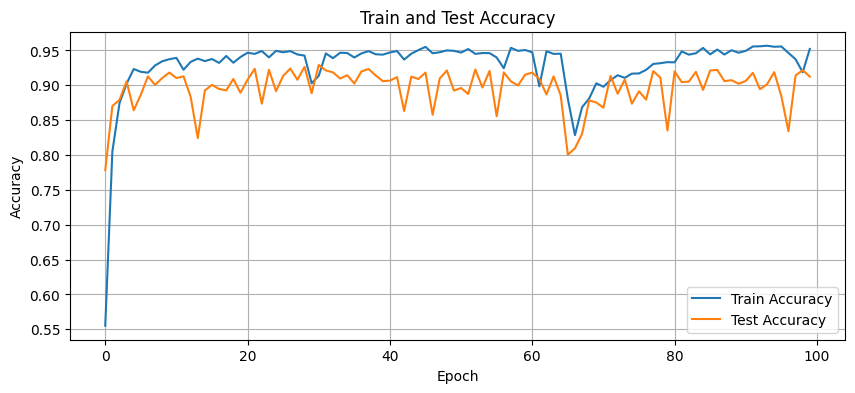

In [63]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()
plt.grid()
plt.show()

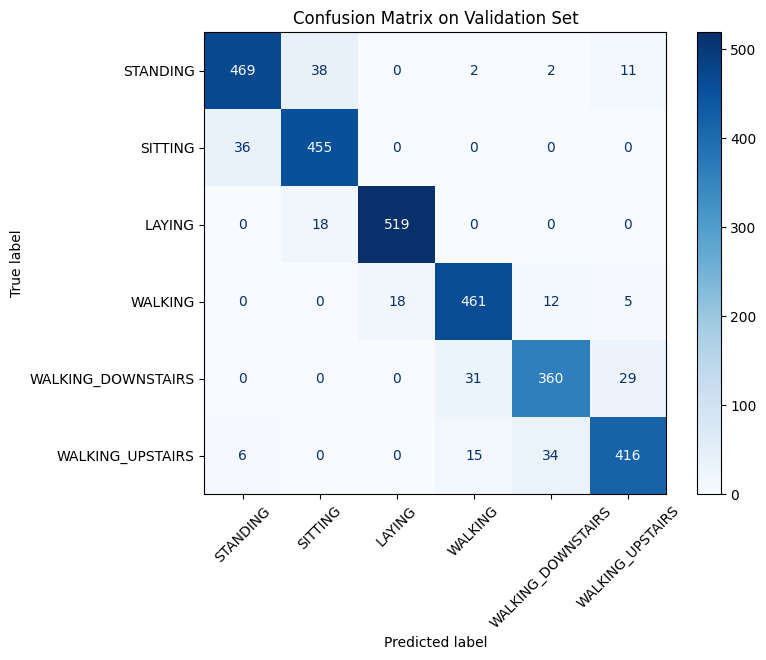

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the validation (test) set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activites)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.show()